Code based on https://github.com/keras-team/keras-io/blob/master/examples/rl/ddpg_pendulum.py and https://arxiv.org/abs/1811.07522 and the DDPG original paper

In [42]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from enviroment import Simulate_Portfolio
from datetime import datetime, timedelta
import keras
import yfinance as yf


Create enviroment and datasets

In [43]:
training_years = 6
validation_years = 1
testing_years = 1
start_datetime = datetime.now() - timedelta(weeks=52*training_years)
validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)


In [44]:
df1 = porfolio.investments['GOOG'].history(start = start_datetime, end = datetime.now(), interval = '1d')

df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-23 00:00:00-04:00,61.695801,62.566343,61.695801,62.528603,18230000,0.0,0.0
2019-10-24 00:00:00-04:00,62.616497,62.770446,62.259690,62.620968,20562000,0.0,0.0
2019-10-25 00:00:00-04:00,62.126355,63.048545,62.075703,62.826565,24262000,0.0,0.0
2019-10-28 00:00:00-04:00,63.339051,64.523943,63.194540,64.061607,52264000,0.0,0.0
2019-10-29 00:00:00-04:00,63.377791,63.643967,62.433353,62.701916,37728000,0.0,0.0


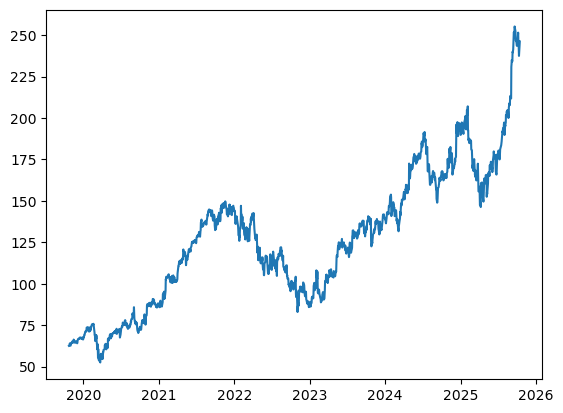

In [45]:
plt.plot(df1['Close'])

In [46]:
df1 = df1['Close']

df1.head()

Date
2019-10-23 00:00:00-04:00    62.528603
2019-10-24 00:00:00-04:00    62.620968
2019-10-25 00:00:00-04:00    62.826565
2019-10-28 00:00:00-04:00    64.061607
2019-10-29 00:00:00-04:00    62.701916
Name: Close, dtype: float64

Supporting Functions

In [47]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
            
def reset_enviroment():
    
    training_years = 6
    validation_years = 1
    testing_years = 1
    start_datetime = datetime.now() - timedelta(weeks=52*training_years)
    validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
    testing_years = datetime.now() - timedelta(weeks = 52*testing_years)

    porfolio = Simulate_Portfolio(start_datetime)
    porfolio.add_investment(name)
    initial_state = porfolio.return_state(name)
    
    return initial_state, porfolio

def policy(state, noise_obj, actor):
    sampled_actions = keras.ops.squeeze(actor(state))
    noise = noise_obj()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise


    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1, 1)

    return [np.squeeze(legal_action)]

def perform_action(action, porfolio, prev_state):
    # :: action, portfolio, prev_state -> state, reward
    
    prev_net = porfolio.get_portfolio_net()
    
    holdings = prev_state[1]
    balance = prev_state[2]
    
    if 1>= action >= 0:
        value = max(balance, 0) * action + holdings
    elif -1<= action < 0:
        value = holdings * (action+1)
    else:
        raise ValueError(f" Action must be between -1 and 1, action {action} ")   
   
    try:
        porfolio.update_investment(name, value)
    except:
        raise ValueError(f"Value update not possible, '\n' value: {value}, action: {action}, balance:{balance}, state: {prev_state}, 1: {max(balance, 0) * action + holdings}, 2: {holdings * (action+1)} ")
    
    porfolio.next_timestep()
    
    reward = porfolio.get_portfolio_net() - prev_net
    return porfolio.return_state(name), reward, value - holdings

        
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)
    

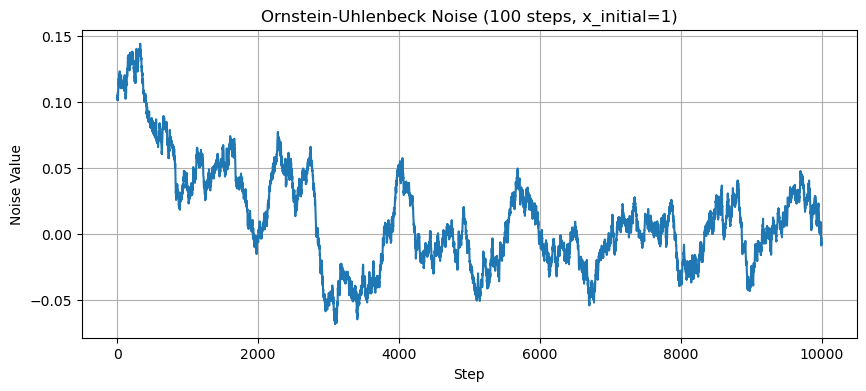

In [48]:
"""Testing the noise setup"""


std_dev = 0.02
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.02) * np.ones(1), x_initial=np.ones(1))
noise = OUActionNoise(mean=np.ones(1)/1e+8, std_deviation=float(std_dev) * np.ones(1))
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), x_initial=np.ones(1)/10)
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), x_initial=np.ones(1)/10)
noise.reset() 
x_vals = []
for _ in range(10000):
    x = noise()
    x_vals.append(x[0])

plt.figure(figsize=(10, 4))
plt.plot(x_vals)
plt.title("Ornstein-Uhlenbeck Noise (100 steps, x_initial=1)")
plt.xlabel("Step")
plt.ylabel("Noise Value")
plt.grid(True)
plt.show()


Model Setup

In [49]:
from keras import layers
from tensorflow.keras.layers import LeakyReLU

num_states = 3
num_actions = 1


def get_actor():

    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(inputs)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * 1
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    state_input = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(state_input)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    state_out = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128)(concat)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128, activation="sigmoid")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model





Training Hyperparams

In [50]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)


# Discount factor for future rewards
gamma = 0.90
# Used to update target networks
tau = 0.001 # recently changed from 0.005 to 0.0001

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Buffer

In [51]:
class Buffer:
    def __init__(self, models, buffer_capacity=100_000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training = True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training = True)
            
            critic_value = critic_model([state_batch, action_batch], training = True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training = True)
            critic_value = critic_model([state_batch, actions], training = True)
            actor_loss = -keras.ops.mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)




Main

In [52]:
total_episodes = 20
print(f"Training run from {start_datetime} to {validation_datetime} with {total_episodes} episodes")


Training run from 2019-10-23 00:07:14.504120 to 2024-10-16 00:07:14.504161 with 20 episodes


In [53]:

buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

start_time = start_datetime
end_time = validation_datetime
ep_profit = []
all_states = []
all_actions = []
    
for ep in range(total_episodes):
    
    ep_start = datetime.now()
    prev_state, porfolio = reset_enviroment()
    episodic_reward = 0
    step = 0
    
    episodic_actions = []
    episodic_val_diff = []
    episodic_timesteps = []
    episodic_full_state = []

    print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")
    
    while porfolio.datetime < end_time:
        
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )
        
        action = policy(tf_prev_state, ou_noise, actor_model)
        
        state, reward, value_change = perform_action(action[0], porfolio, prev_state)
        
                
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        episodic_actions.append(action)
        episodic_val_diff.append(value_change)
        episodic_full_state.append([prev_state])

        prev_state = state 

        step+=1

    all_states.append(episodic_full_state)
    ep_reward_list.append(episodic_reward)
    
    ep_profit.append(porfolio.calc_profit())
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode profit -- start: {porfolio.init_balane}, end: {porfolio.get_portfolio_net()}, profit: {porfolio.calc_profit()}")
    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    print(f"Ending state: {state}, datetime: {porfolio.datetime.strftime('%d-%m-%Y')}\n")
    avg_reward_list.append(avg_reward)
    all_actions.append(episodic_actions)

    


Starting episode: 0, with datetime 23-10-2019, ending at 16-10-2024, state: [ 61.71765137   0.         100.        ]
Episode 0, with avarage 0.13063205562505684, time: 0m 19s, with 1253 timesteps
Episode profit -- start: 100.0, end: 263.6819656981962, profit: 163.68196569819622
Episode actions -- avg action: 0.9139098836345646, latest:1.0
Episodic value changes -- reward: 163.68196569819622 avg change: 0.07980845969672785, latest:0.0 

Ending state: [166.01342773 263.6819657    0.        ], datetime: 16-10-2024

Starting episode: 1, with datetime 23-10-2019, ending at 16-10-2024, state: [ 61.71765137   0.         100.        ]
Episode 1, with avarage 0.13486717463077286, time: 0m 16s, with 1253 timesteps
Episode profit -- start: 100.0, end: 268.9885698123584, profit: 168.98856981235838
Episode actions -- avg action: 0.9298949483117327, latest:1.0
Episodic value changes -- reward: 168.98856981235838 avg change: 0.07980845969672785, latest:0.0 

Ending state: [166.01342773 268.98856981  

In [54]:
actor_model.save_weights("./params/actor_weights.weights.h5")
critic_model.save_weights("./params/critic_weights.weights.h5")

Testing

In [55]:
end_time = datetime.now() - timedelta(weeks = 1)

In [56]:
print(f"Testing datetime from {validation_datetime} to {end_time} ")

Testing datetime from 2024-10-16 00:07:14.504161 to 2025-10-08 00:12:34.942852 


In [57]:
# training_years = 6
# validation_years = 1
# testing_years = 1
# start_datetime = datetime.now() - timedelta(weeks=52*training_years)
# validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
# testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

start_datetime = validation_datetime


name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)

In [58]:

    

training_portfolio = Simulate_Portfolio(validation_datetime)
training_portfolio.add_investment(name)
initial_state = training_portfolio.return_state(name)
prev_state = initial_state
porfolio = training_portfolio
episodic_reward = 0
step = 0

episodic_actions = []
episodic_val_diff = []
episodic_timesteps = []
episodic_full_state = []

print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")

while porfolio.datetime < end_time:

    tf_prev_state = keras.ops.expand_dims(
        keras.ops.convert_to_tensor(prev_state), 0
    )
    
    action = policy(tf_prev_state, ou_noise, actor_model)
    
    state, reward, value_change = perform_action(action[0], porfolio, prev_state)
    
            
    buffer.record((prev_state, action, reward, state))
    episodic_reward += reward
    
    # buffer.learn()

    # update_target(target_actor, actor_model, tau)
    # update_target(target_critic, critic_model, tau)

    episodic_actions.append(action)
    episodic_val_diff.append(value_change)
    episodic_full_state.append([prev_state])

    prev_state = state 
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    
    avg_reward_list.append(avg_reward)

Starting episode: 19, with datetime 16-10-2024, ending at 08-10-2025, state: [166.17269897   0.         100.        ]
Episode 19, with avarage -inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: -1.4319907249519588 avg change: 100.0, latest:100.0 

Episode 19, with avarage -inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: -1.1084273757898586 avg change: 50.0, latest:50.0 

Episode 19, with avarage -inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: -0.6590547509553062 avg change: 33.333333333333336, latest:33.333333333333336 

Episode 19, with avarage -inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: -0.04792340776107551 avg change: 25.0, latest:25.0 

Episode 19, with avarage -inf, time: 0m 16s, with 0 timesteps
Episode a

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24900\2785358604.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")


Episode 19, with avarage inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 14.599624215838418 avg change: 1.6666666666666667, latest:0.0 

Episode 19, with avarage inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 18.156672354300056 avg change: 1.639344262295082, latest:0.0 

Episode 19, with avarage inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 16.61508862846125 avg change: 1.6129032258064515, latest:0.0 

Episode 19, with avarage inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 18.498591498080756 avg change: 1.5873015873015872, latest:0.0 

Episode 19, with avarage inf, time: 0m 16s, with 0 timesteps
Episode actions -- avg action: 1.0, latest:1.0
Episodic value changes -- reward: 19.746252947808372 avg change: 1.562

In [59]:
print(episodic_full_state)

[[array([166.17269897,   0.        , 100.        ])], [array([163.79312134,  98.56800928,   0.        ])], [array([164.33079529,  98.89157262,   0.        ])], [array([165.07752991,  99.34094525,   0.        ])], [array([166.09306335,  99.95207659,   0.        ])], [array([163.76324463,  98.55002996,   0.        ])], [array([163.81303406,  98.57999242,   0.        ])], [array([166.26231384, 100.05392876,   0.        ])], [array([167.60643005, 100.86279581,   0.        ])], [array([170.39422607, 102.54044565,   0.        ])], [array([175.37245178, 105.53626009,   0.        ])], [array([171.93748474, 103.46915336,   0.        ])], [array([171.89764404, 103.44517788,   0.        ])], [array([169.93623352, 102.26483325,   0.        ])], [array([170.66305542, 102.70222273,   0.        ])], [array([177.55291748, 106.84842852,   0.        ])], [array([181.48568726, 109.21510475,   0.        ])], [array([179.07623291, 107.76513472,   0.        ])], [array([181.17703247, 109.02936137,   0.     

In [60]:
print(episodic_full_state)

[[array([166.17269897,   0.        , 100.        ])], [array([163.79312134,  98.56800928,   0.        ])], [array([164.33079529,  98.89157262,   0.        ])], [array([165.07752991,  99.34094525,   0.        ])], [array([166.09306335,  99.95207659,   0.        ])], [array([163.76324463,  98.55002996,   0.        ])], [array([163.81303406,  98.57999242,   0.        ])], [array([166.26231384, 100.05392876,   0.        ])], [array([167.60643005, 100.86279581,   0.        ])], [array([170.39422607, 102.54044565,   0.        ])], [array([175.37245178, 105.53626009,   0.        ])], [array([171.93748474, 103.46915336,   0.        ])], [array([171.89764404, 103.44517788,   0.        ])], [array([169.93623352, 102.26483325,   0.        ])], [array([170.66305542, 102.70222273,   0.        ])], [array([177.55291748, 106.84842852,   0.        ])], [array([181.48568726, 109.21510475,   0.        ])], [array([179.07623291, 107.76513472,   0.        ])], [array([181.17703247, 109.02936137,   0.     

In [61]:
prices = np.array(episodic_full_state)[:,:,0]
holdings = np.array(episodic_full_state)[:,:,1]
balance = np.array(episodic_full_state)[:,:,2]

In [62]:
print(holdings)

[[  0.        ]
 [ 98.56800928]
 [ 98.89157262]
 [ 99.34094525]
 [ 99.95207659]
 [ 98.55002996]
 [ 98.57999242]
 [100.05392876]
 [100.86279581]
 [102.54044565]
 [105.53626009]
 [103.46915336]
 [103.44517788]
 [102.26483325]
 [102.70222273]
 [106.84842852]
 [109.21510475]
 [107.76513472]
 [109.02936137]
 [109.83823761]
 [108.14261764]
 [106.26125429]
 [104.18815139]
 [105.93170396]
 [107.59736147]
 [106.24926196]
 [101.40204663]
 [ 99.80230102]
 [101.51588194]
 [102.22889299]
 [102.34872447]
 [102.15099794]
 [103.64290441]
 [103.6668707 ]
 [105.50630681]
 [104.43979749]
 [105.74596058]
 [106.23183359]
 [111.88833837]
 [117.9947208 ]
 [116.14721329]
 [114.79757112]
 [118.8644953 ]
 [118.24065539]
 [114.05975817]
 [113.78982973]
 [115.74532331]
 [117.56283164]
 [118.51058383]
 [118.22865388]
 [116.3931387 ]
 [115.58336258]
 [114.23372041]
 [114.34769346]
 [115.84728567]
 [118.74451691]
 [117.9947208 ]
 [117.20293318]
 [115.87127951]
 [115.34341497]
 [114.59962422]
 [118.15667235]
 [116.61

In [63]:
print(balance)

[[100.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]


In [64]:
print(prices)

[[166.17269897]
 [163.79312134]
 [164.33079529]
 [165.07752991]
 [166.09306335]
 [163.76324463]
 [163.81303406]
 [166.26231384]
 [167.60643005]
 [170.39422607]
 [175.37245178]
 [171.93748474]
 [171.89764404]
 [169.93623352]
 [170.66305542]
 [177.55291748]
 [181.48568726]
 [179.07623291]
 [181.17703247]
 [182.52116394]
 [179.70350647]
 [176.57719421]
 [173.13226318]
 [176.02957153]
 [178.79743958]
 [176.55726624]
 [168.5025177 ]
 [165.84417725]
 [168.69168091]
 [169.87651062]
 [170.07563782]
 [169.74707031]
 [172.22621155]
 [172.26603699]
 [175.32267761]
 [173.5504303 ]
 [175.72091675]
 [176.52830505]
 [185.9278717 ]
 [196.07501221]
 [193.00495911]
 [190.76222229]
 [197.52033997]
 [196.48368835]
 [189.53617859]
 [189.08763123]
 [192.33712769]
 [195.35733032]
 [196.93223572]
 [196.46374512]
 [193.41362   ]
 [192.06799316]
 [189.82525635]
 [190.01464844]
 [192.50656128]
 [197.32096863]
 [196.07501221]
 [194.75927734]
 [192.5464325 ]
 [191.66926575]
 [190.43328857]
 [196.34413147]
 [193.78

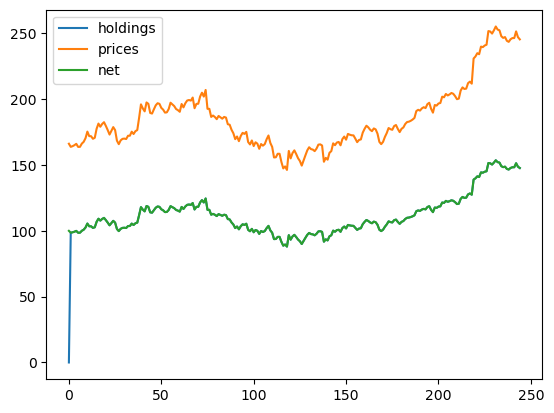

In [65]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
# plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

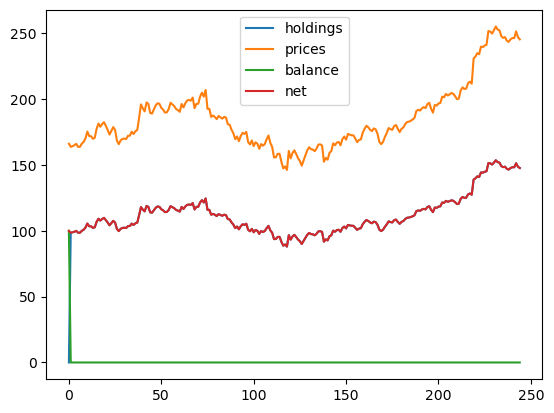

In [66]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

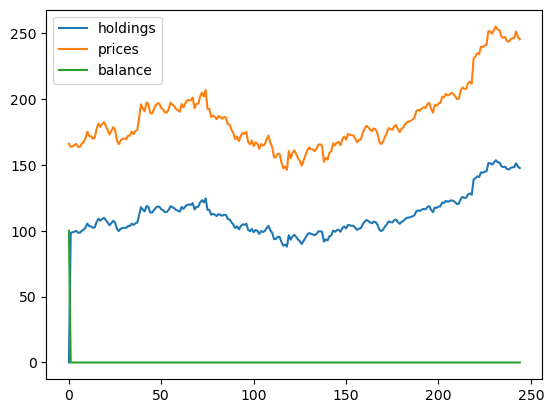

In [67]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.legend()

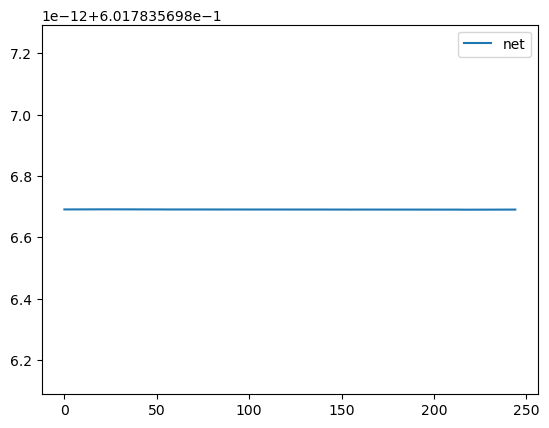

In [68]:
timestep = list(range(len(holdings)))


plt.plot(timestep, (balance + holdings) / prices, label = 'net')
plt.legend()

This should be increasing not decreasing for a succesful model

In [69]:
print(episodic_actions)

[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]

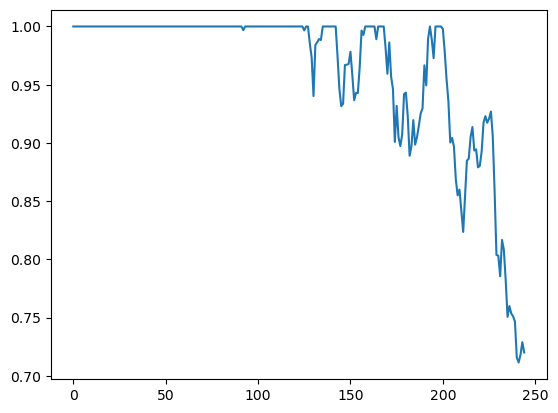

In [70]:
plt.plot(episodic_actions)